In [5]:
import plotly.express as px
import pandas as pd
import numpy as np
import geopandas as gpd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output
import ujson
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')
%matplotlib inline

# Visualizing Epigrass Simulations
Copy this notebook to the `outdata-<yoursim>` directory and adjust variable names accordingly
## Loading the map

In [8]:
path = '../../demos/outdata-rio'
mapdf = gpd.read_file(os.path.join(path,'Data.gpkg'))
mapdf['casesp100k'] = 1e5*mapdf.prevalence
mapdf.head()

geocode            name  \
0  4550601.0  Santo Cristo 1   
1  4550602.0  Santo Cristo 2   
2  4550603.0      Rodoviaria   
3  4550604.0    Santo Cristo   
4  4550605.0      Praca Maua   

                                              colors  prevalence   totalcases  \
0  ['#80ccffff', '#80ccffff', '#80ccffff', '#8026...    0.000000     0.000000   
1  ['#80260080', '#80260080', '#80260080', '#8026...    0.996881  9065.635702   
2  ['#80260080', '#80260080', '#80260080', '#8026...    0.996243  1863.971165   
3  ['#80260080', '#80260080', '#80260080', '#8026...    0.992767  2418.380988   
4  ['#80260080', '#80260080', '#80260080', '#8026...    0.999773  2103.523287   

    arrivals  population                                           geometry  \
0        0.0      7374.0  POLYGON ((-43.19659 -22.89768, -43.19636 -22.8...   
1   314256.0      9094.0  POLYGON ((-43.19873 -22.90058, -43.19826 -22.9...   
2   675040.0      1871.0  POLYGON ((-43.19601 -22.89227, -43.19608 -22.8...   
3   599867.0      2436.0  POLYGON ((-43.19659 -22.89768, -43.19701 -22.8...   
4  1279151.0      2104.0  POLYGON ((-43.18805 -22.89789, -43.18811 -22.8...   

     casesp100k  
0      0.000000  
1  99688.098763  
2  99624.327344  
3  99276.723653  
4  99977.342548

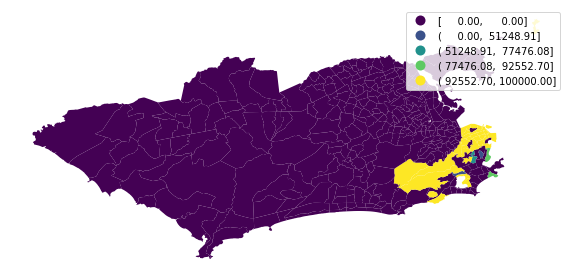

In [9]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
mapdf.plot(ax=ax, column='casesp100k', legend=True, scheme='NaturalBreaks');
ax.set_axis_off()

## Loading the Simulated series

In [12]:
from sqlalchemy import create_engine
import os
full_path = os.path.join(path,'Epigrass.sqlite')
def get_sims():
    full_path = os.path.join(path,'Epigrass.sqlite')
    if os.path.exists(full_path):
        con = create_engine(f'sqlite:///{os.path.abspath(full_path)}?check_same_thread=False').connect()
        sims = con.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
        return [s[0] for s in sims if not (s[0].endswith('_meta') or s[0].endswith('e'))]
    else:
        return ['No simulations found']

In [11]:
sim_select = widgets.Select(
    options=get_sims(),
#     value='OSX',
    description='Simulations available:',
    disabled=False
)
display(sim_select)

Select(description='Simulations available:', options=('rio_Sat_Sep__7_091054_2019', 'rio_Sun_Nov_29_164629_202…

In [13]:
simulation = sim_select.get_interact_value()
con = create_engine(f'sqlite:///{os.path.abspath(full_path)}?check_same_thread=False').connect()
simdf = pd.read_sql_table(simulation, con)
simdf.fillna(0, inplace=True)
simdf

geocode  time            name            lat        longit  Exposed  \
0      4550601     0  Santo Cristo 1  685271.205900  7.466409e+06      0.0   
1      4550601     1  Santo Cristo 1  685271.205900  7.466409e+06      0.0   
2      4550601     2  Santo Cristo 1  685271.205900  7.466409e+06      0.0   
3      4550601     3  Santo Cristo 1  685271.205900  7.466409e+06      0.0   
4      4550601     4  Santo Cristo 1  685271.205900  7.466409e+06      0.0   
...        ...   ...             ...            ...           ...      ...   
51295  4553603   145          Mare 3  679950.150595  7.472358e+06      0.0   
51296  4553603   146          Mare 3  679950.150595  7.472358e+06      0.0   
51297  4553603   147          Mare 3  679950.150595  7.472358e+06      0.0   
51298  4553603   148          Mare 3  679950.150595  7.472358e+06      0.0   
51299  4553603   149          Mare 3  679950.150595  7.472358e+06      0.0   

       Infectious  Susceptible  incidence  Arrivals  
0             0.0       7374.0        0.0       0.0  
1             0.0          0.0        0.0       0.0  
2             0.0          0.0        0.0       0.0  
3             0.0          0.0        0.0       0.0  
4             0.0          0.0        0.0       0.0  
...           ...          ...        ...       ...  
51295         0.0          0.0        0.0       0.0  
51296         0.0          0.0        0.0       0.0  
51297         0.0          0.0        0.0       0.0  
51298         0.0          0.0        0.0       0.0  
51299         0.0          0.0        0.0       0.0  

[51300 rows x 10 columns]

In [18]:
city_select = widgets.Select(
    options=set(simdf.name),
    value='Rodoviaria',
    description='Cities available:',
    disabled=False
)
@interact(city=city_select,time=(simdf.time.min(),simdf.time.max(),1),var=['Exposed','Infectious','Susceptible','incidence','Arrivals'])
def animate(city='TEFÉ', time=50, var='Infectious'):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
#     mapa = mapdf[mapdf.NM_MICRO==city]
    values = simdf[(simdf.name==city)&(simdf.time==time)][var].iloc[0]
    mapa = pd.merge(mapdf, simdf[simdf.time==time][['name', 'time', var]], left_on='name', right_on='name')

    simdf[simdf.name==city].plot(x='time',y=var, ax=ax1)
    ax1.set_title(f'{city}')
    ax1.vlines(time,0,simdf[simdf.name==city][var].max())
    ax1.grid()
    
    mapa.plot(ax=ax2, column=var, legend=True);
    ax2.set_title(f'{var} time={time}')
    ax2.set_axis_off()
    clear_output(wait=True)
    

interactive(children=(Select(description='Cities available:', index=220, options=(0, 'Embau', 'General Gliceri…

In [19]:
import hvplot.pandas

In [25]:
mapdf.hvplot.polygons(geo=True, c='incidence', clabel='name', colorbar=True )

:Polygons   [Longitude,Latitude]